Uncomment line to download and extract dataset

In [46]:
# !wget -P ./root "https://cloud.dfki.de/owncloud/index.php/s/TwrjNFYpTCEdeKB/download"
# !unzip ./root/download
# !tar -xvzf "./AAI WS2022/bens2.tar.gz"


Uncomment line to create environment and install required depenancies

In [47]:
# conda env create -f environment.yml

In [48]:

BigEarthNetlabels = {
    "Urban fabric": 0,
    "Industrial or commercial units": 1,
    "Arable land": 2,
    "Permanent crops": 3,
    "Pastures": 4,
    "Complex cultivation patterns": 5,
    "Land principally occupied by agriculture, with significant areas of natural vegetation": 6,
    "Agro-forestry areas": 7,
    "Broad-leaved forest": 8,
    "Coniferous forest": 9,
    "Mixed forest": 10,
    "Natural grassland and sparsely vegetated areas": 11,
    "Moors, heathland and sclerophyllous vegetation": 12,
    "Transitional woodland, shrub": 13,
    "Beaches, dunes, sands": 14,
    "Inland wetlands": 15,
    "Coastal wetlands": 16,
    "Inland waters": 17,
    "Marine waters": 18
}


Create Training, Validation and Test data sets 

In [49]:
import cv2
import numpy as np
import os
import torch
import pandas as pd
import json


def getFilePath(dirName, fileName):
        path = './netscratch/siddamsetty/kosovo_files/{}/{}_{}'.format(
            dirName, dirName, fileName)
        return path

# Merge RGB bands and return numpy image array
def getNumpyImageCv2( dirName):
        blue = cv2.imread(getFilePath(dirName, "B02.tif"),
                          cv2.IMREAD_UNCHANGED)
        blue = (blue-np.min(blue))/(np.max(blue)-np.min(blue))
        green = cv2.imread(getFilePath(
            dirName, "B03.tif"), cv2.IMREAD_UNCHANGED)
        green = (green-np.min(green))/(np.max(green)-np.min(green))
        red = cv2.imread(getFilePath(dirName, "B04.tif"),
                         cv2.IMREAD_UNCHANGED)
        red = (red-np.min(red))/(np.max(red)-np.min(red))
        return cv2.resize(cv2.merge([red, green, blue]), dsize=(224, 224))

def loadJson( dirName):
        path = './netscratch/siddamsetty/kosovo_files/{}/{}_labels_metadata.json'.format(
            dirName, dirName)
        with open(getFilePath(dirName, "labels_metadata.json")) as json_data:
            return json.load(json_data)

def extractLablels(fileList):
        lablesList = np.zeros(shape=(len(fileList), 20), dtype=np.object_)
        for index, dirName in enumerate(fileList):
            labelMetadata = loadJson(dirName)
            labels = labelMetadata.get('labels')
            lablesList[index, 0] = dirName
            for label in labels:
                if BigEarthNetlabels.get(label) is not None:
                    lablesList[index, BigEarthNetlabels.get(label)+1] = 1
        np.savetxt('lables.csv',
                   lablesList, delimiter=",", fmt="%s")

fileList = os.listdir(path='./netscratch/siddamsetty/kosovo_files/')

valSplit = int(np.floor(0.2*len(fileList)))
testSplit = valSplit
trainSplit = len(fileList) - valSplit - testSplit
train_set, val_set, test_set = torch.utils.data.random_split(fileList, [trainSplit, valSplit, testSplit])

def save(name, datset):
        if not os.path.exists("./data/"+name):
            os.makedirs("./data/"+name)
        lablesList = np.zeros(shape=(len(datset), 20), dtype=np.object_)
        for index, dirName in enumerate(datset):
            image = getNumpyImageCv2(dirName)*255
            # print(np.shape(image))
            cv2.imwrite("./data/"+name+"/"+dirName+'.jpg', image)
            labelMetadata = loadJson(dirName)
            labels = labelMetadata.get('labels')
            lablesList[index, 0] = dirName
            for label in labels:
                if BigEarthNetlabels.get(label) is not None:
                    lablesList[index, BigEarthNetlabels.get(label)+1] = 1
        np.savetxt("./data/"+name+'/lablels.csv',
                   lablesList, delimiter=",", fmt="%s")

save("train",train_set)
save("val",val_set)
save("test",test_set)


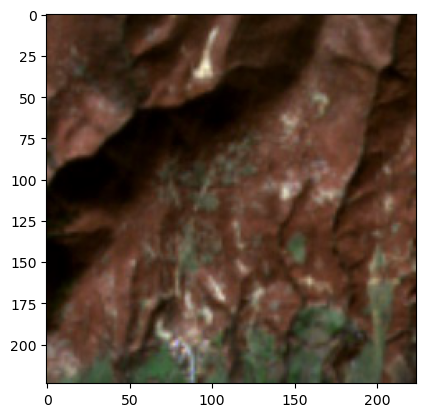

In [51]:
import matplotlib.pyplot as plt


imageRead = cv2.imread("./data/test/S2A_MSIL2A_20171208T093351_48_71.jpg")
plt.imshow(imageRead)
plt.show()

Creating Dataset and Dataloader class for training